**This file is used to assign tag to a law question**

It follow this implementation https://viblo.asia/p/xac-dinh-y-dinh-cau-hoi-trong-he-thong-hoi-dap-oOVlYnXQ58W

# Preparation

Install Pyvi for document data handling features

## Check for GPU 

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Resources path

In [23]:
qa_data_path = '/content/drive/MyDrive/University/Transportation Legal Text Retrieval/Intent Question/resources/university_intent_db.json'
stopwords_path = '/content/drive/MyDrive/University/Transportation Legal Text Retrieval/Intent Question/resources/stopwords.csv'
train_path = '/content/drive/MyDrive/University/Transportation Legal Text Retrieval/Intent Question/resources/train.xlsx'
wiki_data_path = '/content/drive/MyDrive/University/Transportation Legal Text Retrieval/Intent Question/resources/xaa'
fasttext_gensim_model_path = '/content/drive/MyDrive/University/Transportation Legal Text Retrieval/Intent Question/models/fasttext_genshim.model'

## Import libraries

In [4]:
! pip3 install pyvi

     |████████████████████████████████| 8.5 MB 4.6 MB/s 
     |████████████████████████████████| 965 kB 39.6 MB/s 


In [37]:
import pandas as pd
import os
import re 
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyvi.ViTokenizer import tokenize # Vietnamese tokenizer
from gensim.models.fasttext import FastText 
from tensorflow.keras.utils import to_categorical

## Read data file

In [6]:
data = pd.read_excel(train_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2172 non-null   object
 1   intent   2172 non-null   object
dtypes: object(2)
memory usage: 34.1+ KB


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Preprocessing Data

## Remove unnecessary symbols

In [7]:
def clean_text(text):
  text = re.sub('<.*?>','',text).strip()
  text = re.sub('(\s)+', r'\1', text)
  return text

## Sentence Segmentation

In [8]:
def sentence_segment(text):
    sents = re.split("([.?!])?[\n]+|[.?!] ", text)
    return sents

## Word segmentation

In [9]:
def word_segment(sent):
    sent = tokenize(sent)
    return sent

## Normalize sentence

In [10]:
def normalize_text(text):
    listpunctuation = string.punctuation.replace('_', '')
    for i in listpunctuation:
        text = text.replace(i, ' ')
    return text.lower()

## Remove special characters

In [11]:
def remove_special_characters(text):
  chars = re.escape(string.punctuation)
  return re.sub(r'['+chars+']', '', text)

## Remove stop words

In [17]:
def remove_stopword(text):

    filename = stopwords_path
    data = pd.read_csv(filename, sep="\t", encoding='utf-8')
    list_stopwords = data['stopwords']

    pre_text = []
    words = text.split()
    for word in words:
        if word not in list_stopwords:
            pre_text.append(word)
        text2 = ' '.join(pre_text)
    return text2

## Sentence Embedding

In [16]:
max_length_inp = 30
def sentence_embedding(sent):
    content = clean_text(sent) 
    content = remove_special_characters(content) 
    content = word_segment(content)
    content = remove_stopword(normalize_text(content))
    inputs = []
    for word in content.split():
      if word in fast_text_model.wv.vocab:
        inputs.append(fast_text_model.wv.get_vector(word))
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                                maxlen=max_length_inp,
                                                                dtype='float32',
                                                                padding='post')
    return inputs


# Using FastText as a model for word2vec

## Read Wiki Data Path

In [24]:
import json 

def read_wiki_data(path):
    traindata = []
    sents = open(wiki_data_path, 'r').readlines()
    for sent in sents:
        traindata.append(sent.split())
    with open(qa_data_path) as json_file:
        qa_data = json.load(json_file)  
        for question in qa_data: 
            if 'content' in question :
              content = clean_text(question['content']) 
              content = remove_special_characters(content) 
              content = word_segment(content)
              content = remove_stopword(normalize_text(content))
              traindata.append(content.split())
    print("Corpus loaded")
    return traindata, qa_data
train_data, qa_data = read_wiki_data(wiki_data_path)

Corpus loaded


## Retrieve fast text model

### Train a scratch fast text model

In [ ]:
model_fasttext = FastText(size=150, window=10, min_count=2, workers=4, sg=1)

In [ ]:
model_fasttext.build_vocab(train_data)
model_fasttext.train(train_data, total_examples=model_fasttext.corpus_count, epochs=model_fasttext.iter)

In [ ]:
model_fasttext.wv.save(fasttext_gensim_model_path)

### Load pretrained fast text model

In [25]:
from gensim.models import KeyedVectors

fast_text_model = KeyedVectors.load(fasttext_gensim_model_path)

## Retrieve Q&A data

In [26]:
import json 

def read_qa_data(qa_data_input):
  sentences = [] 
  labels = []
  intents = [] 
  for question in qa_data: 
    if 'intent' in question:
      if question['intent'] not in intents: 
        # Read all intents in database
        intents.append(question['intent']) 
      sentences.append(sentence_embedding(question['content'])[0])
      labels.append(intents.index(question['intent']))
  print("Corpus loaded")
  return sentences, labels, intents

 # Labels is the label of the question
 # Intents is the list of intent in the database
 # Sentences is content (question)
sentences, labels, intents = read_qa_data(qa_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


Corpus loaded


Test the number of dimension of a word

In [27]:
fast_text_model.wv.get_vector("hôm_nay").shape 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(150,)

## Processing Dataset

### Demonstrate dataset

In [30]:
label_list = np.array(labels)
count_classes = [np.count_nonzero(label_list == i) for i in range(len(intents)) ]
print(count_classes)

[297, 91, 650, 534, 520, 138, 188, 548, 514, 100, 9]


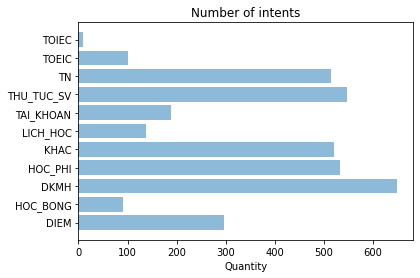

In [31]:
objects = (intent for intent in intents)
y_pos = np.arange(len(intents))
performance = count_classes

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Quantity')
plt.title('Number of intents')

plt.show()

### Handling imbalanced dataset

In [32]:
def split_balanced(data, target, test_size=0.2):

    classes = np.unique(target)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test

In [38]:
trainX = np.array(sentences)

trainy = to_categorical(np.array(labels), len(intents))

X_train, X_test, y_train, y_test = split_balanced(trainX, trainy, test_size=0.2)

# Training classification model

## Import libraries

In [39]:
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import *

## Create training model

In [40]:
def build_model():
  model = Sequential()

  model.add(LSTM(128, input_shape=(max_length_inp, fast_text_model.vector_size)))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(len(intents), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.summary()
  return model

In [41]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                                 
Total params: 151,819
Trainable params: 151,819
Non-trainable params: 0
_________________________________________________________________


## Adding log

In [42]:
import datetime
logdir = os.path.join("logs_dev_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [43]:
tf.config.list_physical_devices('GPU')

[]

## Start training

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=10,verbose=1,  validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
287/287 [==============================] - 13s 46ms/step - loss: 0.0089 - accuracy: 0.9958 - val_loss: 1.5175 - val_accuracy: 0.8315
Epoch 2/50
287/287 [==============================] - 10s 33ms/step - loss: 0.0076 - accuracy: 0.9951 - val_loss: 1.5907 - val_accuracy: 0.8329
Epoch 3/50
287/287 [==============================] - 10s 36ms/step - loss: 0.0083 - accuracy: 0.9951 - val_loss: 1.6148 - val_accuracy: 0.8329
Epoch 4/50
287/287 [==============================] - 9s 31ms/step - loss: 0.0095 - accuracy: 0.9948 - val_loss: 1.6410 - val_accuracy: 0.8315
Epoch 5/50
287/287 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9962

KeyboardInterrupt: ignored

In [45]:
model.save('./models/model-epochs-300')

INFO:tensorflow:Assets written to: ./models/model-epochs-300/assets


INFO:tensorflow:Assets written to: ./models/model-epochs-300/assets


In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: ignored

# Evaluating model

## Import libraries

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

## Evaluation

In [64]:
!kill 1575

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs_dev_3

In [53]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=10)
print("test loss, test acc:", results)

Evaluate on test data
72/72 [==============================] - 1s 12ms/step - loss: 1.5201 - accuracy: 0.8315
test loss, test acc: [1.520125150680542, 0.8314763307571411]


In [54]:
y_test_arg=np.argmax(y_test,axis=1) # If we use raw y_text it would throw Classification metrics can't handle a mix of multilabel-indicator and multiclass  error
y_prediction = np.argmax(model.predict(X_test),axis=1)

report = classification_report(y_test_arg,y_prediction,target_names=intents)
print('Classification Report\n')
print(report)

Classification Report

              precision    recall  f1-score   support

        DIEM       0.92      0.90      0.91        68
    HOC_BONG       0.85      0.94      0.89        18
        DKMH       0.75      0.90      0.82       114
     HOC_PHI       0.94      0.84      0.89       117
        KHAC       0.72      0.78      0.75        87
    LICH_HOC       0.82      0.61      0.70        44
   TAI_KHOAN       0.88      0.84      0.86        43
  THU_TUC_SV       0.81      0.85      0.83       117
          TN       0.90      0.84      0.87        94
       TOEIC       0.70      0.54      0.61        13
       TOIEC       1.00      0.67      0.80         3

    accuracy                           0.83       718
   macro avg       0.84      0.79      0.81       718
weighted avg       0.84      0.83      0.83       718



In [55]:
y_test_true = np.array([np.where(label ==1)[0][0] for label in y_test])
f1 = f1_score(y_prediction, y_test_true, average='weighted')

print(f'f1-score: {f1}')

f1-score: 0.8316132955047307


## External Testing

In [61]:
prediction = model.predict(sentence_embedding('Học bổng toàn phần giá trị bao nhiêu?'))
predicted_classes = np.argmax(prediction, 1)
predicted_classes
print(f'Topic: {intents[predicted_classes[0]]}')

Topic: HOC_BONG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [57]:
intents

['DIEM',
 'HOC_BONG',
 'DKMH',
 'HOC_PHI',
 'KHAC',
 'LICH_HOC',
 'TAI_KHOAN',
 'THU_TUC_SV',
 'TN',
 'TOEIC',
 'TOIEC']